In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import anndata
from scipy import sparse
from kladi.matrix_models.accessibility_model import AccessibilityModel
from kladi.matrix_models.expression_model import ExpressionModel

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

atac_data = anndata.read_h5ad('data/shareseq/2021-02-01_atac_data.h5ad')
peaks = np.array(atac_data.var[['chr','start','end']].values.tolist())

atac_model = AccessibilityModel(peaks, num_modules = 24)

INFO:root:Using CUDA: True


In [1]:
atac_model.fit(atac_data.X, batch_size = 32)
atac_model.save('data/shareseq/atac_model.pth')

INFO:root:Using CUDA: True
INFO:root:Validating data ...
INFO:root:Binarizing accessibility matrix ...
INFO:root:Initializing model ...
INFO:root:Training ...
100%|██████████| 1087/1087 [02:12<00:00,  8.22it/s]
INFO:root:Epoch 1/100 complete. Training loss: 6.520e+05
100%|██████████| 1087/1087 [02:11<00:00,  8.25it/s]
INFO:root:Epoch 2/100 complete. Training loss: 5.959e+05
100%|██████████| 1087/1087 [02:12<00:00,  8.22it/s]
INFO:root:Epoch 3/100 complete. Training loss: 5.813e+05
100%|██████████| 1087/1087 [02:12<00:00,  8.22it/s]
INFO:root:Epoch 4/100 complete. Training loss: 5.743e+05
100%|██████████| 1087/1087 [02:12<00:00,  8.22it/s]
INFO:root:Epoch 5/100 complete. Training loss: 5.692e+05
100%|██████████| 1087/1087 [02:12<00:00,  8.22it/s]
INFO:root:Epoch 6/100 complete. Training loss: 5.660e+05
100%|██████████| 1087/1087 [02:12<00:00,  8.22it/s]
INFO:root:Epoch 7/100 complete. Training loss: 5.637e+05
100%|██████████| 1087/1087 [02:12<00:00,  8.21it/s]
INFO:root:Epoch 8/100 comp

AccessibilityModel(
  (decoder): Decoder(
    (beta): Linear(in_features=24, out_features=334124, bias=False)
    (bn): BatchNorm1d(334124, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
  (encoder): DANEncoder(
    (drop): Dropout(p=0.2, inplace=False)
    (drop2): Dropout(p=0.2, inplace=False)
    (embedding): Embedding(334124, 128, padding_idx=0)
    (fc1): Linear(in_features=129, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fcmu): Linear(in_features=128, out_features=24, bias=True)
    (fclv): Linear(in_features=128, out_features=24, bias=True)
    (bnmu): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bnlv): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [3]:
gex_data = anndata.read_h5ad('./data/shareseq/2021-05-05_just_raw_counts.h5ad')
gex_data.var.index = gex_data.var.index.str.upper()
gex_data=gex_data[:,~gex_data.var.index.duplicated()]

with open('data/shareseq/model_genes.txt', 'r') as f:
    variable_genes = [x.strip() for x  in f]

In [2]:
expr_model = ExpressionModel(variable_genes, num_modules = 24)
expr_model = expr_model.fit(gex_data[:, variable_genes].X)
expr_model.save('data/shareseq/gex_model.pth')

INFO:root:Using CUDA: True
INFO:root:Validating data ...
INFO:root:Initializing model ...
INFO:root:Training ...
INFO:root:Learning deviance featurization for transcript counts ...
INFO:root:Epoch 1/100 complete. Training loss: 7.975e+03
INFO:root:Epoch 2/100 complete. Training loss: 5.309e+03
INFO:root:Epoch 3/100 complete. Training loss: 3.924e+03
INFO:root:Epoch 4/100 complete. Training loss: 3.043e+03
INFO:root:Epoch 5/100 complete. Training loss: 2.512e+03
INFO:root:Epoch 6/100 complete. Training loss: 2.185e+03
INFO:root:Epoch 7/100 complete. Training loss: 1.967e+03
INFO:root:Epoch 8/100 complete. Training loss: 1.841e+03
INFO:root:Epoch 9/100 complete. Training loss: 1.802e+03
INFO:root:Epoch 10/100 complete. Training loss: 1.792e+03
INFO:root:Epoch 11/100 complete. Training loss: 1.785e+03
INFO:root:Epoch 12/100 complete. Training loss: 1.780e+03
INFO:root:Epoch 13/100 complete. Training loss: 1.776e+03
INFO:root:Epoch 14/100 complete. Training loss: 1.773e+03
INFO:root:Epoch 

In [4]:
expr_model = ExpressionModel(variable_genes, num_modules = 24)
expr_model.load('data/shareseq/gex_model.pth')

INFO:root:Using CUDA: True


In [130]:
enrichments = expr_model.get_enrichments(expr_model.post_genelist(15, top_n_genes = 300))

INFO:root:Querying Enrichr with module 15 genes.
INFO:root:Downloading results ...


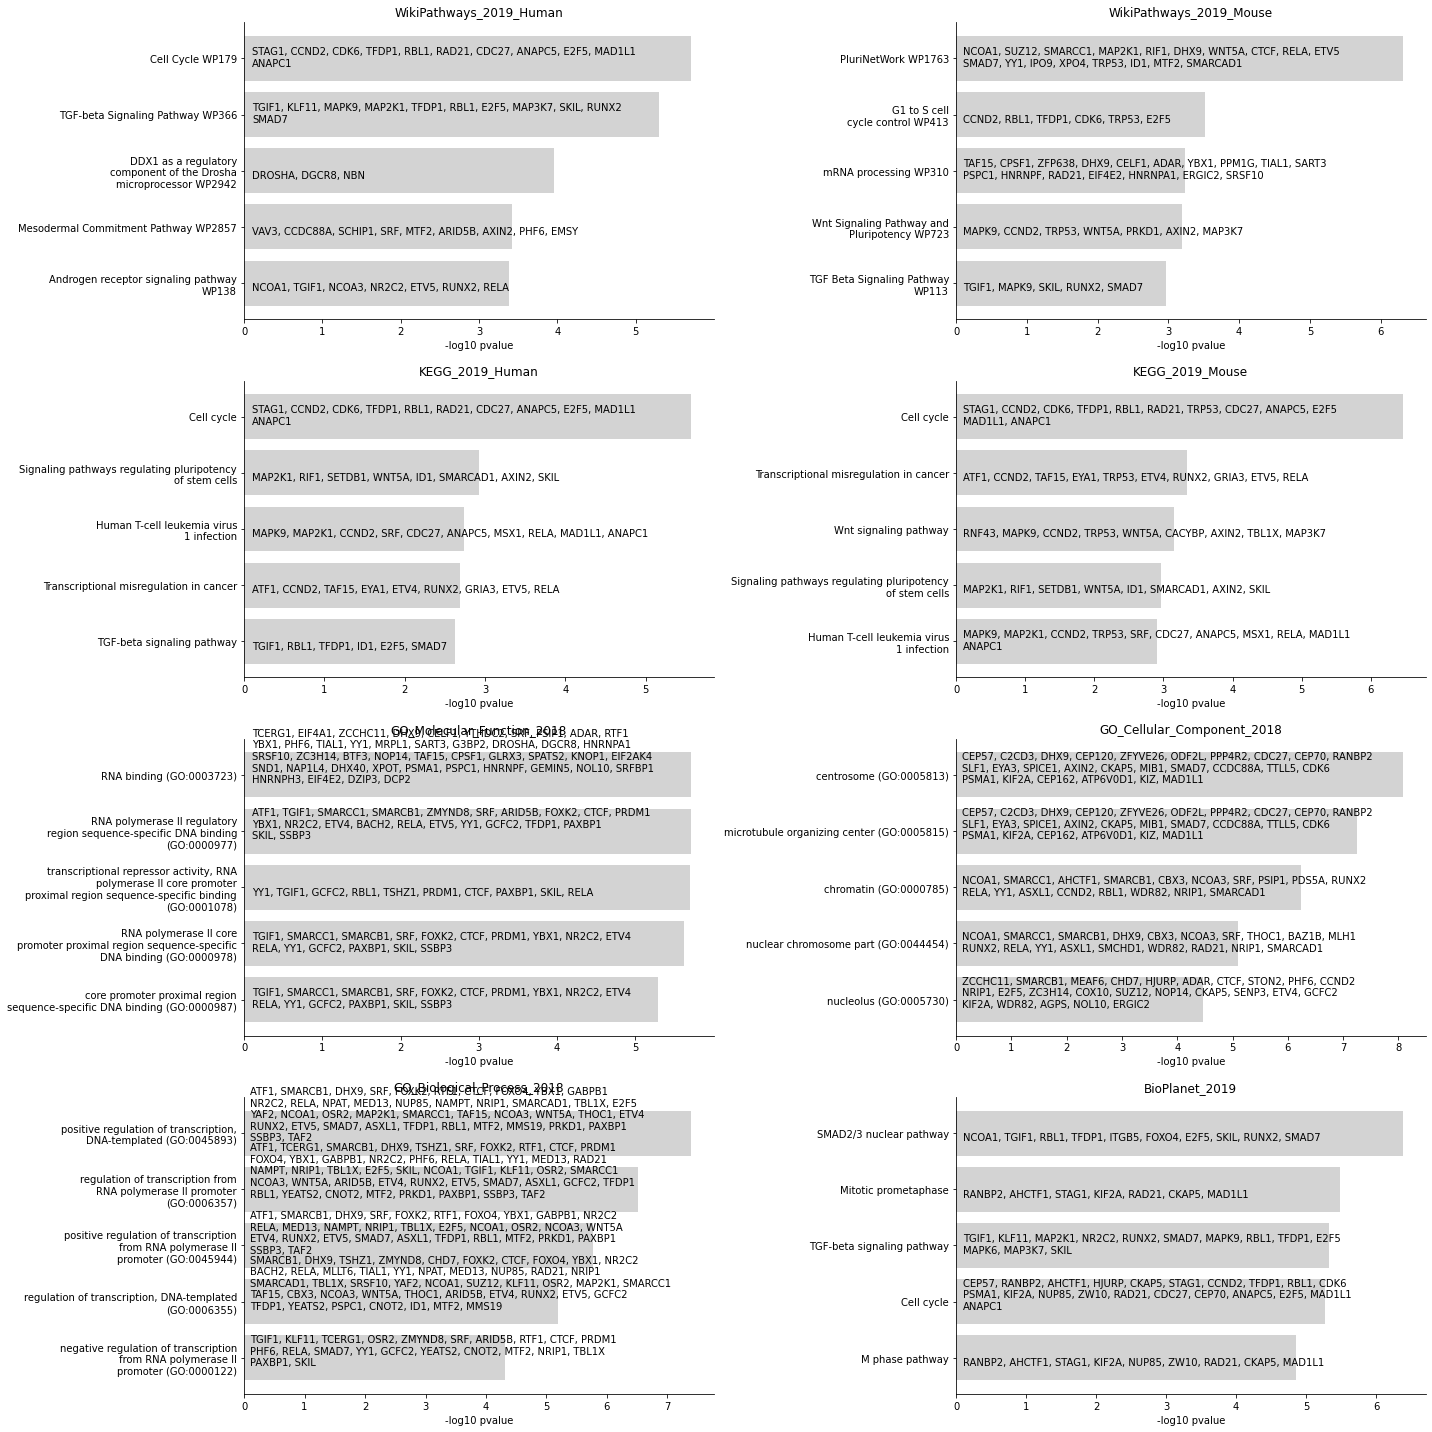

In [131]:
expr_model.plot_enrichments(enrichments)

In [5]:
gex_data.obsm['Z'] = expr_model.predict(gex_data[:, variable_genes].X)
gex_data = gex_data[:, variable_genes]
gex_data.layers['imputed'] = expr_model.impute(gex_data.obsm['Z'])

In [6]:
atac_model.load('data/shareseq/atac_model.pth')
gex_data.obsm['Y'] = atac_model.predict(atac_data.X)

INFO:root:Binarizing accessibility matrix ...
100%|██████████| 1087/1087 [01:34<00:00, 11.50it/s]


In [7]:
from kladi.matrix_models.ilr import ilr

In [8]:
gex_data.obsm['joint'] = np.hstack([1.75 * ilr(gex_data.obsm['Z']), ilr(gex_data.obsm['Y'])])
gex_data.obsm['joint_composition'] = np.hstack([1.5*gex_data.obsm['Z'],gex_data.obsm['Y']])

In [9]:
del atac_model
del expr_model

In [10]:
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

# Manifold

In [11]:
#embedding = UMAP(min_dist = 0.05, metric = 'hellinger').fit_transform(gex_data.obsm['joint_composition'])
embedding = UMAP(min_dist = 0.05, metric = 'euclidean').fit_transform(gex_data.obsm['joint'])

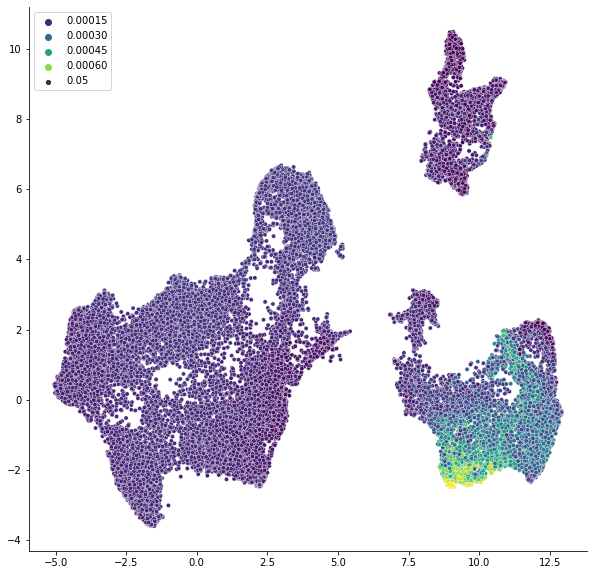

In [12]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sns.scatterplot(x = embedding[:,0], y = embedding[:, 1], hue = gex_data[:, 'GATA3'].layers['imputed'].reshape(-1), 
                size = 0.05, palette= 'viridis')
sns.despine()

In [13]:
from sklearn.neighbors import NearestNeighbors
import igraph as ig
from leidenalg import find_partition, RBConfigurationVertexPartition

In [14]:
def cluster(X, r = 1):
    nbrs = NearestNeighbors(n_neighbors = 15).fit(X)
    n_graph = nbrs.kneighbors_graph(X)

    g = ig.Graph(directed=None)
    g.add_vertices(n_graph.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(n_graph.tocoo().row, n_graph.tocoo().col)))

    clusters = find_partition(g, RBConfigurationVertexPartition, resolution_parameter = r, seed = 2556)

    return clusters.membership

# Supercluster identification

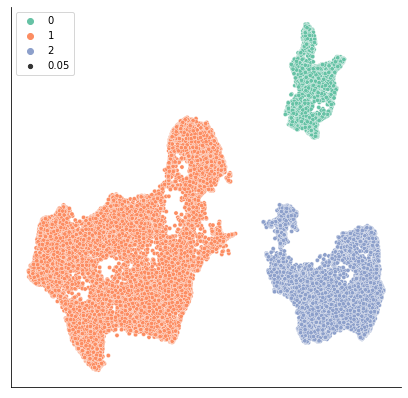

In [131]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(0.5, min_samples = 20).fit_predict(embedding)
fig, ax = plt.subplots(1,1,figsize=(7,7))
sns.scatterplot(x = embedding[:,0], y = embedding[:, 1], hue = clusters, 
                size = 0.05, palette= 'Set2')
sns.despine()
ax.set(xticks = [], yticks = [])
plt.show()

# Pseudotime

In [132]:
hair_follicle = gex_data[clusters == 2, :]

In [133]:
embeddings = UMAP(n_components = 2, min_dist = 0.15, n_neighbors = 15, metric = 'euclidean').fit_transform(hair_follicle.obsm['joint'])

In [134]:
hf_clusters = np.array(cluster(hair_follicle.obsm['joint'], 0.6))

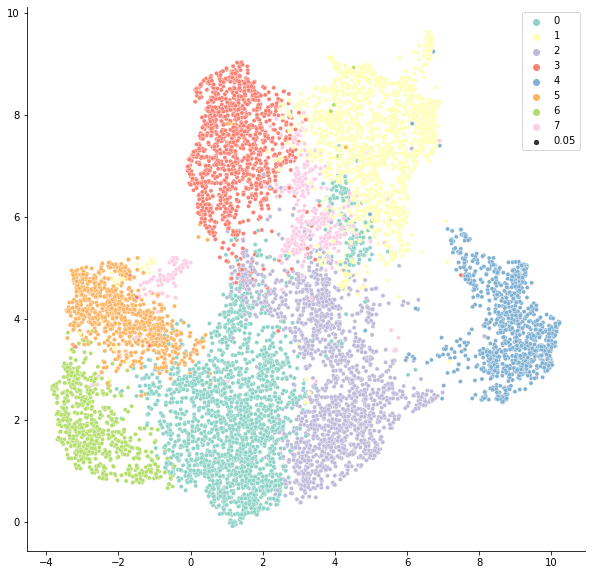

In [135]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sns.scatterplot(x = embeddings[:,0], y = embeddings[:, 1], hue = hf_clusters, 
                size = 0.05, palette= 'Set3')
sns.despine()

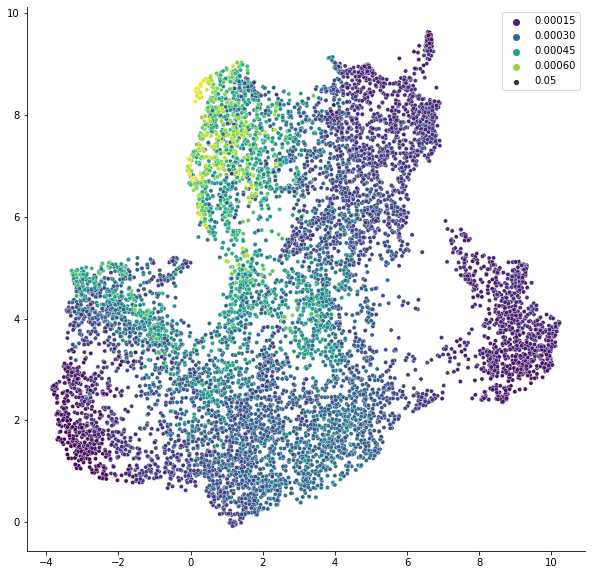

In [139]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sns.scatterplot(x = embeddings[:,0], y = embeddings[:, 1], hue = hair_follicle[:, 'GATA3'].layers['imputed'].reshape(-1), 
                size = 0.05, palette= 'viridis')
sns.despine()

In [166]:
hf_cluster_mask = ~np.isin(hf_clusters, [1,7,4])

In [167]:
hair_follicle = hair_follicle[hf_cluster_mask]

In [170]:
hf_embedding = UMAP(n_components = 3, min_dist = 0.15, n_neighbors = 15, metric = 'euclidean').fit_transform(hair_follicle.obsm['joint'])

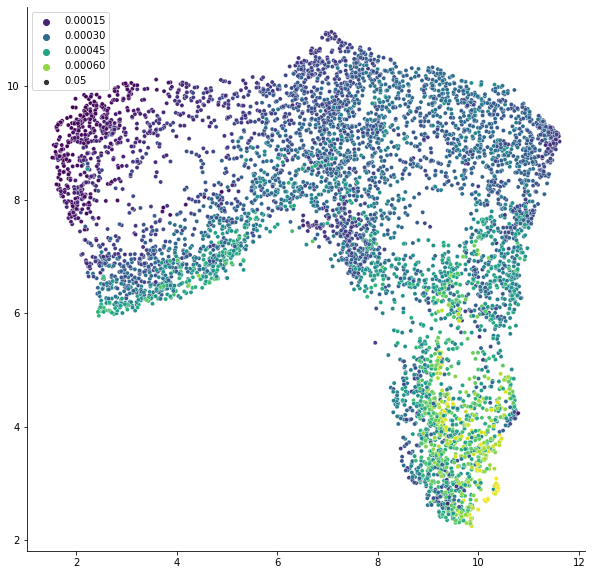

In [171]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sns.scatterplot(x = hf_embedding[:,0], y = hf_embedding[:, 1], hue = hair_follicle[:, 'GATA3'].layers['imputed'].reshape(-1), 
                size = 0.05, palette= 'viridis')
sns.despine()

## Trying Slingshot

In [172]:
from sklearn.mixture import BayesianGaussianMixture

In [189]:
mixture_model = BayesianGaussianMixture(50, weight_concentration_prior = 0.1)
clusters = mixture_model.fit_predict(hf_embedding[:,:2])

/home/allen/miniconda3/envs/cuda/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_components=50 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/home/allen/miniconda3/envs/cuda/lib/python3.8/site-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


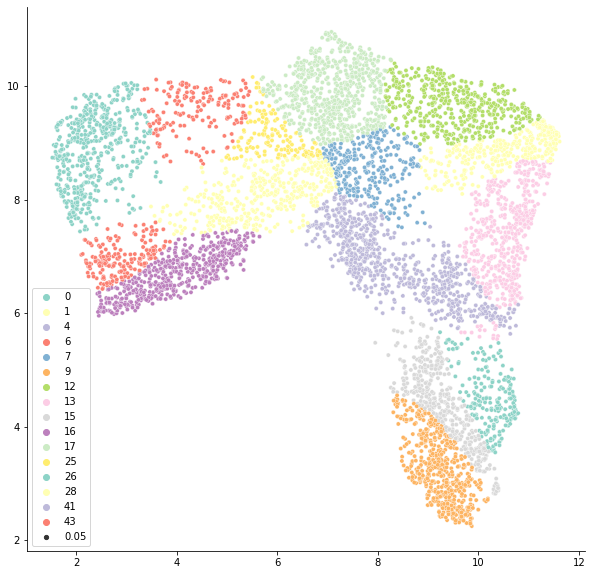

In [190]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
sns.scatterplot(x = hf_embedding[:,0], y = hf_embedding[:, 1], hue = clusters, 
                size = 0.05, palette= 'Set3', legend = True)
    
sns.despine()

In [201]:
#nil_clusters = [7,4,41]
nil_clusters = [41,7]

In [192]:
from matplotlib.patches import Ellipse
from scipy.sparse.csgraph import minimum_spanning_tree

In [193]:
def plot_2D_eclipse(mu,cov, nstd = 1, color = 'lightgrey', alpha = 0.1):
    
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 2 * nstd * np.sqrt(vals)
    
    ell = Ellipse(mu, width = w, height = h, angle = theta, color = 'black')
    ell.set_facecolor('none')
    return ell

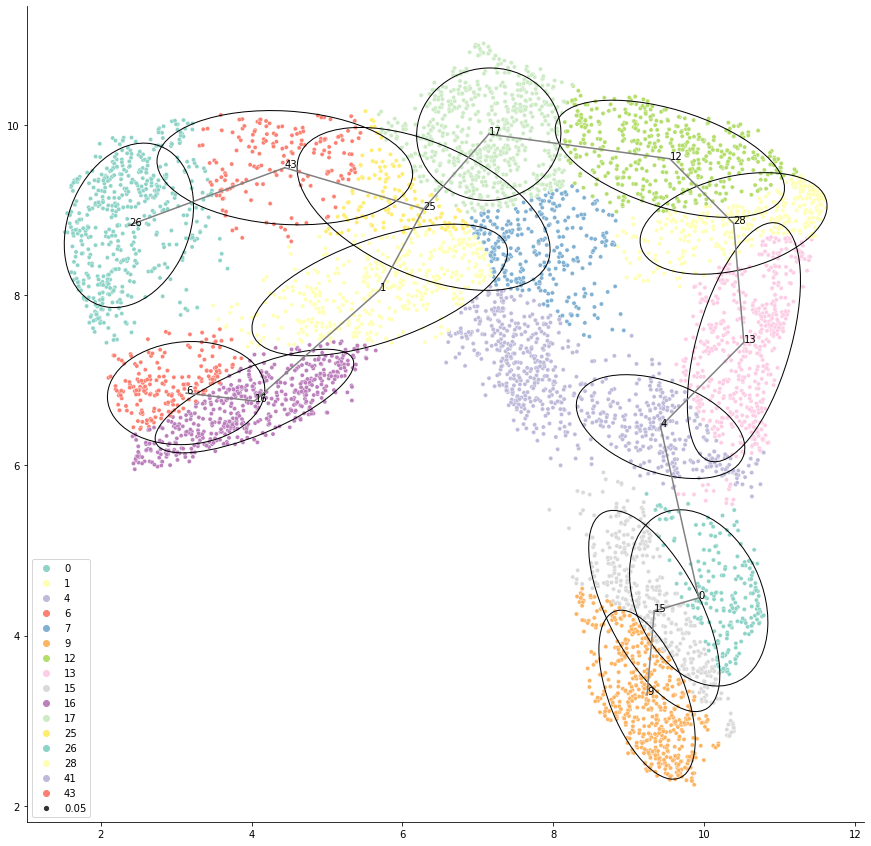

In [202]:
def mahalanobis_intercluster_distance(mu1, mu2, cov1, cov2):
    return np.dot(np.dot((mu1 - mu2).T, np.linalg.inv(cov1 + cov2)), (mu1 - mu2))

cluster_idx = np.unique(clusters)
num_clusters = len(mixture_model.covariances_)
intercluster_distances = np.zeros((num_clusters, num_clusters))

for i in cluster_idx:
    for j in cluster_idx:
        if not i in nil_clusters and not j in nil_clusters:
            intercluster_distances[i,j] = mahalanobis_intercluster_distance(
                mixture_model.means_[i],
                mixture_model.means_[j],
                mixture_model.covariances_[i],
                mixture_model.covariances_[j])


fig,ax = plt.subplots(1,1,figsize=(15,15))
for i in np.unique(clusters):
    if not i in nil_clusters:
        ax.add_artist(
            plot_2D_eclipse(mixture_model.means_[i], mixture_model.covariances_[i], nstd = 1.5,
                            color = sns.color_palette('Set3')[i%12], alpha = 0.2)
        )
        x,y=mixture_model.means_[i]
        ax.text(x,y,s =str(i))
    
sns.scatterplot(x = hf_embedding[:,0], y = hf_embedding[:, 1], hue = clusters, 
                size = 0.05, palette= 'Set3', legend = True, ax =ax)

shade = 1 - intercluster_distances[intercluster_distances.nonzero()]/intercluster_distances[intercluster_distances.nonzero()].max()

'''for i,j,shade in zip(*intercluster_distances.nonzero(), shade):
    sns.lineplot(x = [mixture_model.means_[i, 0], mixture_model.means_[j, 0]],
                y = [mixture_model.means_[i,0], mixture_model.means_[j, 1]], color = sns.color_palette('Reds', as_cmap = True)(np.square(shade) - 0.5))
'''
intercluster_distances = minimum_spanning_tree(intercluster_distances)

for i,j in zip(*intercluster_distances.nonzero()):
    sns.lineplot(x = [mixture_model.means_[i, 0], mixture_model.means_[j, 0]],
                y = [mixture_model.means_[i,1], mixture_model.means_[j, 1]], color = 'grey')

    
sns.despine()